In [1]:
import numpy as np
import healpy as hp
import pymaster as nmt

import os
import matplotlib.pyplot as plt
import sys
import broom

from broom import _compute_spectra
from matplotlib.legend_handler import HandlerTuple
from matplotlib.offsetbox import TextArea, VPacker, AnnotationBbox
from broom import (
    Configs,
    get_params,
    component_separation,_get_full_simulations, estimate_residuals)

import matplotlib.ticker as tck

root_path = os.path.dirname(os.path.abspath(broom.__file__))


### 📘 Introduction to Configuration Parameters

See `configs/config_demo.yaml` and the notebook `tutorial_satellite.ipynb` for a detailed explanation of all configuration parameters.

---

### 🛰️ Tutorial: Simulations Generation

An example of simulations generation is provided in the notebook:  
`tutorial_satellite.ipynb`

### 🧪 Tutorial: Component Separation

Learn how to perform component separation using:  
- `tutorial_satellite.ipynb`
- `tutorial_satellite_v2.ipynb`


In [2]:
# Importing all general parameter from satellite config file
config_path = root_path + "/configs/config_satellite.yaml"

config: Configs = get_params(config_path=config_path)
print("Loaded configuration from\n", config_path)


Loaded configuration from
 /home/alecarones/anaconda3/envs/test_install_last/lib/python3.11/site-packages/broom/configs/config_satellite.yaml


In [3]:
#Generation of input data

data = _get_full_simulations(config, nsim = 0)

# Running component separation

config.config["field_out"] = "EB"
config._store_passed_settings()   # refresh all dependent attributes

# ILC in needlet domain (NILC)
config_run = {
    'compsep': [{'method': "ilc", 'domain': "needlet", 'ilc_bias': 0.001,
    'needlet_config':
      [{'needlet_windows': "mexican"},
       {'width': 1.3},
       {'merging_needlets': [0, 14, 17, 19, 40]}],
    'adapt_nside': True, 'save_needlets': True, 'save_weights': True,
}]}

config.config["compsep"] = config_run["compsep"]
config._store_passed_settings()   # refresh all dependent attributes

outputs_nilc = component_separation(config, data, nsim = 0)

# Estimate the foreground residuals through GNILC run

# Configuration for running GILC.
config_run = {
    'compsep': [{'method': "gilc",'domain': "needlet", 
    'needlet_config':
      [{'needlet_windows': "mexican"},
       {'width': 1.3},
       {'merging_needlets': [0,10,14,17,40]}],
    'ilc_bias': 0.1, 'adapt_nside': True, 'cmb_nuisance': True, 'depro_cmb': [None, 0., 0.,], #[None,0.,0.,0.]
    'm_bias': [0,1,1,1], 'channels_out': [i for i in range(len(config.instrument.frequency))],
}]}

config.config["compsep"] = config_run["compsep"]
config._store_passed_settings()   # refresh all dependent attributes

outputs_gilc = component_separation(config, data, nsim = 0)

config_run = {
    'compsep_residuals': [{'gnilc_path': "gilc_needlet_bias0.1_m+1_nls1-2-3_deproCMB0.0_nls1-2/mexican_B1.3_j0j9_j10j13_j14j16_j17j39", 
    'compsep_path': "ilc_needlet_bias0.001/mexican_B1.3_j0j13_j14j16_j17j18_j19j39",
    'adapt_nside': True
}]}

config.config["compsep_residuals"] = config_run["compsep_residuals"]
config._store_passed_settings()   #

outputs_res = estimate_residuals(config, nsim=0)

Generating foreground maps of d1s1 model


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Generating CMB simulation 00000
Generating noise simulation 00000
Generating coadded signal for simulation 00000
Pre-processing input alms for component separation for simulation 00000.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.


/home/alecarones/anaconda3/envs/test_install_last/lib/python3.11/site-packages/broom/inputs.py:451: RuntimeWarning: divide by zero encountered in divide
  pixwin_inv = 1. / np.array(hp.pixwin(config.nside_in, pol=True, lmax=config.lmax))


Running ilc in needlet domain for simulation 00000.


setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]


Pre-processing input alms for component separation for simulation 00000.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running gilc in needlet domain for simulation 00000.
No nuisance alms provided. Using input noise and CMB alms as nuisance.


setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [d

Running foregrounds residuals estimation for simulation 00000.
Path outputs/LiteBIRD_PTEP/d1s1/gilc_needlet_bias0.1_m+1_nls1-2-3_deproCMB0.0_nls1-2/mexican_B1.3_j0j9_j10j13_j14j16_j17j39/fgds_residuals/00000 contains the expected foregrounds residuals. The ideal template of foregrounds residuals with no CMB and noise contamination will be computed
Inputs are assumed to be at common angular resolution
Correcting for input pixel window function


setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64')]


## Computation of angular power spectra

In [4]:
# Here we initialize the main parameters for power spectrum computation
# Note that some parameters already imported from config file matter for power spectrum computation
config_cls_values = {
    # Binning, if > 1, the power spectrum will be binned with bins of size delta_ell. Default: 1
    'delta_ell': 1, 
    # tool to compute the power spectrum, either 'anafast' or 'namaster'.
    'spectra_comp': 'anafast',
    # If True, power spectra will be saved and/or returned as Dls.
    'return_Dell': False, 
    # Angular power spectra fields to be computed; it can include both auto power spectra and cross-spectra.
    # Examples: "TTEEBBTEEBTB", "BB", "TTEETE"
    # If cross power spectra are needed, all of them should be included in the string, 
    # e.g. "TTEEBBTE" is not allowed, but "TTEEBBTEEBTB" is.
    'field_cls_out': "BB", # Let's compute only B-mode power spectrum
    # If True, the code will return the computed angular power spectra
    'return_spectra': True, 
    # If True, the code will save the computed angular power spectra in the method specific path
    # A different subfolder will be generated for each masking approach.
    'save_spectra': True,  
    # If True, masks for some specific masking approaches will be saved. Default: False
    'save_mask': True,
}

config.config.update(config_cls_values)
config._store_passed_settings()   # refresh all dependent attributes


In [5]:
# In this cell all the keywords for power spectrum specific computation are shown.

# Types of mask which are currently implemented:
# - "GAL*": Planck Galactic mask with specific fraction of sky (e.g. "GAL40" for 40% of sky).
# - "from_fits": it will load the mask from the path specified in 'mask_path' keyword (see below).
# - "GAL*+fgres": it will load the Planck Galactic mask with the specified fraction of sky and 
#      further regions will be masked based on foreground residuals map upon the fsky specified with 'fsky' keyword (see below).
# - "GAl*+fgtemp": it will load the Planck Galactic mask with the specified fraction of sky and
#      mask further regions based on foreground residuals template map upon the fsky specified with 'fsky' keyword.
#      The path to foreground residual template must be specified in ''fgres_temp_for_masking''.
# - "fgres" or "fgtemp": it will threshold the foreground residuals map or template map, respectively, 
#      to genereate the mask with final sky fraction set by 'fsky' keyword.
# - "config": the mask specified in config.mask_covariance will be used. 
#      If config.mask_covariance is None, but mask_observations is not None, that will be used.
# - "config+fgres": the mask specified in config will be used and 
#      further regions will be masked based on foreground residuals map upon the fsky specified with 'fsky' keyword.
# - "config+fgtemp": the mask specified in config will be used and 
#      further regions will be masked based on foreground residuals template map upon the fsky specified with 'fsky' keyword.
    
config_cls_run = {
    'compute_spectra': [{
    # Path to the component separation outputs. 
    # The total path will be given by {config.path_outputs} + 'path_method'.
    'path_method': "ilc_needlet_bias0.001/mexican_B1.3_j0j13_j14j16_j17j18_j19j39",
    # List of output components from compsep for which power spectrum is computed.
    # As shown below it can include templates of foreground residuals.
    'components_for_cls': ["output_total", "noise_residuals", "fgds_residuals", "output_cmb"],
    # Type of mask to be used. Further details above and in config_demo.yaml
    'mask_type': "GAL60+fgres",
    # If mask_type is "from_fits", the mask will be loaded from the full path 'mask_path'
    'mask_path':"",
    # Fields associated to the outputs returned by the component separation run. 
    # Even though, e.g. you want to compute only B-mode power spectrum,
    # you need to specify all the fields saved by the component separation run of your interest 
    # (i.e. the config.field_out you used for component separation)
    'field_out': 'EB',
    # Apodization scheme for the mask. It can be None, "gaussian", "gaussian_nmt", "C1", "C2".
    # For the last three options, it will use 'pymaster' to perform the apodization.
    'apodize_mask': "gaussian", #"C1",
    # Apodization scale for the mask in degrees. Used if apodization mask is not None.  
    'smooth_mask': 2.,
    # If not null, it will apply a smoothing with a Gaussian beam with FWHM=smooth_tracer (in deg) 
    # to the tracer (fgres or fgtemp) eventually used to generate the mask. 
    'smooth_tracer': 3.,
    # Desired final sky fraction for the mask. Used if "fgres" or "fgtemp" is used in mask_type.
    'fsky': 0.5,
    # If True and 'spectra_comp' is 'nanamaster', it will perform purification 
    # for B-mode power spectra computation.
    'nmt_purify_B': True,
    # If True and 'spectra_comp' is 'nanamaster', it will perform purification for 
    # E-mode power spectra computation.
    'nmt_purify_E': False,
    # Name of the subfolder storing the fgd residual template to be used if 'fgtemp' is in mask_type
    'fgres_temp_for_masking': 'gilc_needlet_bias0.1_m+1_nls1-2-3_deproCMB0.0_nls1-2_mexican_B1.3_j0j9_j10j13_j14j16_j17j39'
    },
        
    {'path_method': "ilc_needlet_bias0.001/mexican_B1.3_j0j13_j14j16_j17j18_j19j39",
    'components_for_cls': ["output_total", "noise_residuals", "fgds_residuals", "output_cmb"],
    'mask_type': "GAL60", 'field_out': 'EB',
    'apodize_mask': "gaussian", 'smooth_mask': 2., 'nmt_purify_B': True,
    'nmt_purify_E': False,
    },
        
    {'path_method': "ilc_needlet_bias0.001/mexican_B1.3_j0j13_j14j16_j17j18_j19j39",
    'components_for_cls': ["output_total", "noise_residuals", "fgds_residuals", "output_cmb"],
    'mask_type': "GAL40", 'field_out': 'EB',
    'apodize_mask': "gaussian", 'smooth_mask': 2., 'nmt_purify_B': True,
    'nmt_purify_E': False,
    },
        
    {'path_method': "ilc_needlet_bias0.001/mexican_B1.3_j0j13_j14j16_j17j18_j19j39",
    'components_for_cls': ["output_total", "noise_residuals", "fgds_residuals", "output_cmb"],
    'mask_type': "GAL60+fgtemp^3", 'mask_path':"", 'field_out': 'EB',
    'apodize_mask': "gaussian", 'smooth_mask': 2., 'smooth_tracer': 10., 'fsky': 0.5, 'nmt_purify_B': True,
    'nmt_purify_E': False, 'fgres_temp_for_masking': 'gilc_needlet_bias0.1_m+1_nls1-2-3_deproCMB0.0_nls1-2_mexican_B1.3_j0j9_j10j13_j14j16_j17j39'
    }
    ]}

config.config["compute_spectra"] = config_cls_run["compute_spectra"]
config._store_passed_settings()   # refresh all dependent attributes


In [6]:
# Let's compute the spectra

cls_out = _compute_spectra(config)

print(f'Attributes of "cls_out" are {", ".join(vars(cls_out).keys())}')

# Shape corresponds to (n_sims, n_cases, n_fields, n_bins)
print(f'Shape of each attribute is {cls_out.fgds_residuals.shape}')

/home/alecarones/anaconda3/envs/test_install_last/lib/python3.11/site-packages/broom/spectra.py:313: RuntimeWarning: divide by zero encountered in divide
  cl /= np.mean(mask**2) * beam**2
setting the output map dtype to [dtype('float64')]


Mask type does not include 'fgres' or 'fgtemp', not saving mask.
Mask type does not include 'fgres' or 'fgtemp', not saving mask.


setting the output map dtype to [dtype('float64')]


Attributes of "cls_out" are output_total, noise_residuals, fgds_residuals, output_cmb
Shape of each attribute is (1, 4, 1, 149)


In [7]:
# Let's import and bin the theoretical power spectrum
b_bin = nmt.NmtBin.from_lmax_linear(config.lmax, nlb=config.delta_ell, is_Dell=config.return_Dell)  
ell = np.arange(config.lmax+1)

field = 2 # we asked for BB spectrum

cls_r0 = hp.read_cl(root_path + '/utils/Cls_Planck2018_lensed_r0.fits')
cls_r0 = cls_r0[field,:config.lmax+1]
cls_r0 = b_bin.bin_cell(cls_r0)

cls_r1 = hp.fitsfunc.read_cl(root_path + '/utils/Cls_Planck2018_tensor_r1.fits')
cls_r1_BB = cls_r1[2,:config.lmax+1]
cls_r1_BB = b_bin.bin_cell(cls_r1_BB)

ell_bin = b_bin.get_effective_ells()


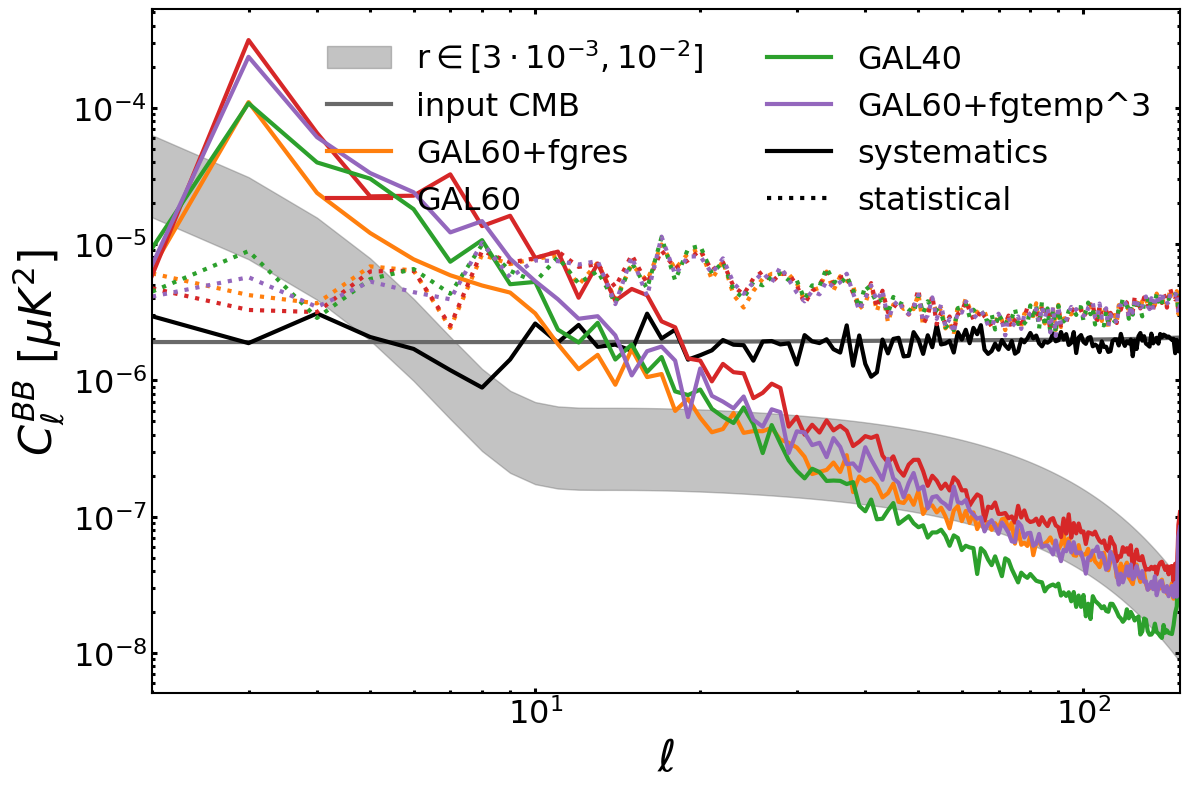

In [8]:
field=0
bmin=0

fig, ax = plt.subplots(figsize=(12,8))
plt.xlabel("$\ell$", fontsize=32)
plt.ylabel("$C_{\ell}^{BB}\ [\mu K^{2}]$", fontsize=32)

# plt.ylim(1e-9, 5e-3)
plt.xlim(config.lmin,config.lmax)

plt.fill_between(ell_bin,0.001*cls_r1_BB,0.004*cls_r1_BB,color='dimgrey',alpha=0.4,label=r'r$\in [3\cdot 10^{-3},10^{-2}]$')

cols=['C1','C3','C2','C4','C5','C6']
labs=['GAL60+fgres', 'GAL60', 'GAL40', 'GAL60+fgtemp^3']
p=plt.plot(ell_bin, cls_r0,linewidth=3.,label='input CMB',color='dimgrey')
p=plt.plot(ell_bin[bmin:], np.mean(cls_out.output_cmb[:,0,field,bmin:],axis=0),linewidth=3.,color='k')
for k in range(cls_out.output_total.shape[1]):
#     p=plt.plot(ell_bin[bmin:], np.mean(cls_out.output_total[:,k,field,bmin:],axis=0),linewidth=3.,label=labs[k],color=cols[k])
    p=plt.plot(ell_bin[bmin:], np.mean(cls_out.fgds_residuals[:,k,field,bmin:],axis=0),linewidth=3.,label=labs[k],color=cols[k], linestyle='-')
    p=plt.plot(ell_bin[bmin:], np.mean(cls_out.noise_residuals[:,k,field,bmin:],axis=0),linewidth=3., linestyle=':',color=plt.gca().lines[-1].get_color())
    
plt.plot(ell_bin,-0.01*cls_r1_BB,color='k', label='systematics',linewidth=3.)
plt.plot(ell_bin,-0.01*cls_r1_BB,color='k', linestyle=':', label='statistical',linewidth=3.)

plt.legend(loc='upper right',ncol=2,fontsize=23,frameon=False)
plt.tight_layout()

for side in ax.spines.keys():
    ax.spines[side].set_linewidth(1.5)

ax.tick_params(direction='in', which='both', labelsize = 23, width = 2.2)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.yscale('log')
plt.xscale('log')
plt.tight_layout()


In [9]:
# Saved power spectra can also be loaded

from broom import _load_cls

path_method = "ilc_needlet_bias0.001/mexican_B1.3_j0j13_j14j16_j17j18_j19j39"
path = os.path.join(config.path_outputs, path_method)
field_cls_out = 'BB'
components = ["output_total", "noise_residuals", "fgds_residuals", "output_cmb"]
mask_folder = "GAL60+fgres_fsky0.5_3.0deg_apogaussian_2.0deg"

loaded_cls = _load_cls(path, components, field_cls_out, mask_folder, config.nside, 
                       config.lmax, config.fwhm_out, nsim=0, return_Dell = config.return_Dell)

print(f'Shape of loaded outputs is {loaded_cls.shape}')


Shape of loaded outputs is (4, 149)


## 📊 Angular Power Spectrum of Foreground Residuals estimate

Estimate the **angular power spectrum** of the **foreground residuals templates**  

In [10]:
# If you want to compute also the power spectrum of fgd residuals template
# They should be added in 'components_for_cls'

config_cls_run = {
    'compute_spectra': [{
    'path_method': "ilc_needlet_bias0.001/mexican_B1.3_j0j13_j14j16_j17j18_j19j39",
    'components_for_cls': ["output_total", "noise_residuals", "fgds_residuals", "output_cmb", 
    "fgres_templates/gilc_needlet_bias0.1_m+1_nls1-2-3_deproCMB0.0_nls1-2_mexican_B1.3_j0j9_j10j13_j14j16_j17j39", 
    "fgres_templates_noise/gilc_needlet_bias0.1_m+1_nls1-2-3_deproCMB0.0_nls1-2_mexican_B1.3_j0j9_j10j13_j14j16_j17j39"],
    'mask_type': "GAL60",'mask_path':"",'field_out': 'EB','apodize_mask': None, #"C1",
    'smooth_mask': 0., 'smooth_tracer': 3., 'fsky': 0.5, 'nmt_purify_B': True,'nmt_purify_E': False,
    'fgres_temp_for_masking': ''
    },
    ]}

config.config["compute_spectra"] = config_cls_run["compute_spectra"]
config._store_passed_settings()   # refresh all dependent attributes

cls_out = _compute_spectra(config)


Mask type does not include 'fgres' or 'fgtemp', not saving mask.


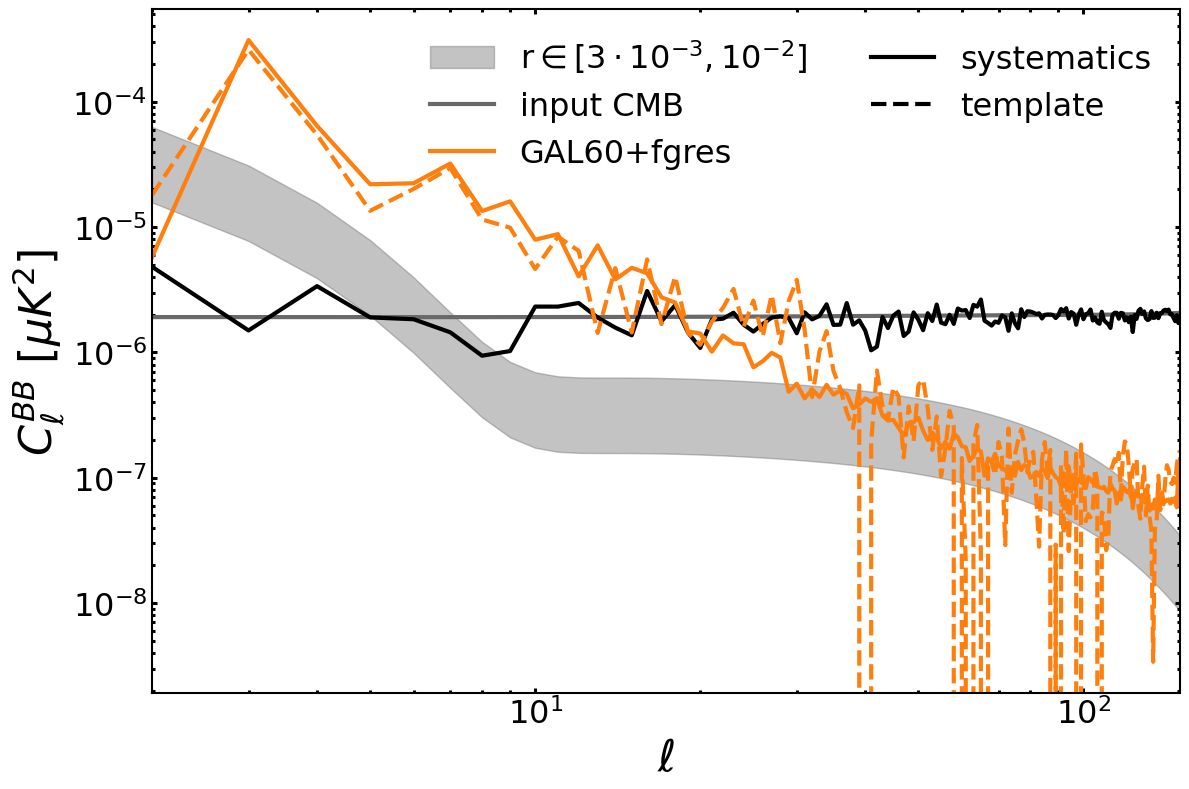

In [11]:
field=0
bmin=0

fig, ax = plt.subplots(figsize=(12,8))
plt.xlabel("$\ell$", fontsize=32)
plt.ylabel("$C_{\ell}^{BB}\ [\mu K^{2}]$", fontsize=32)

# plt.ylim(1e-9, 5e-3)
plt.xlim(config.lmin,config.lmax)

plt.fill_between(ell_bin,0.001*cls_r1_BB,0.004*cls_r1_BB,color='dimgrey',alpha=0.4,label=r'r$\in [3\cdot 10^{-3},10^{-2}]$')

cols=['C1','C3','C2','C4','C5','C6']
labs=['GAL60+fgres', 'GAL60', 'GAL40', 'GAL60+fgtemp^3']
p=plt.plot(ell_bin, cls_r0,linewidth=3.,label='input CMB',color='dimgrey')
p=plt.plot(ell_bin[bmin:], np.mean(cls_out.output_cmb[:,0,field,bmin:],axis=0),linewidth=3.,color='k')
for k in range(cls_out.output_total.shape[1]):
    p=plt.plot(ell_bin[bmin:], np.mean(cls_out.fgds_residuals[:,k,field,bmin:],axis=0),linewidth=3.,label=labs[k],color=cols[k], linestyle='-')
    p=plt.plot(ell_bin[bmin:], np.mean(cls_out.fgres_templates[:,k,field,bmin:],axis=0)-np.mean(cls_out.fgres_templates_noise[:,k,field,bmin:],axis=0),linewidth=3., linestyle='--',color=plt.gca().lines[-1].get_color())
    
plt.plot(ell_bin,-0.01*cls_r1_BB,color='k', label='systematics',linewidth=3.)
plt.plot(ell_bin,-0.01*cls_r1_BB,color='k', linestyle='--', label='template',linewidth=3.)

plt.legend(loc='upper right',ncol=2,fontsize=23,frameon=False)
plt.tight_layout()

for side in ax.spines.keys():
    ax.spines[side].set_linewidth(1.5)

ax.tick_params(direction='in', which='both', labelsize = 23, width = 2.2)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
